In [1]:
import pandas as pd
import numpy as np
import h5py
#import illustris_python as il
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib widget
from tqdm import tqdm_notebook
#import skysurvey_pw as skysurvey
import skysurvey
import requests
import glob
import os

import h5py
from astropy.cosmology import Planck15 as cosmo

from photutils.aperture import CircularAperture,aperture_photometry
from astropy.wcs import WCS
from astropy.visualization import simple_norm
from astropy.io import fits

import warnings
from tqdm.notebook import tqdm

import pandas as pd
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

plt.rcParams['errorbar.capsize']=4

import seaborn as sns 
#plt.style.use('dark_background')
#sns.set_context('paper')
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize': [16,9]})
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams['text.usetex'] = True

In [51]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM, z_at_value
from astropy import units as u
import matplotlib.pyplot as plt


# Cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Star formation history (Madau & Dickinson 2014)
def md14(z):
    return 0.015 * (1 + z)**2.7 / (1 + ((1 + z) / 2.9)**5.6)

# Delay time distribution (power law)
def phi_t_pl(t, tp=0.04, s=-1.0, norm=1.0):
    return ((0*t)*(t<tp)) + ((norm*(t**s))*(t>=tp))

# Time grid and corresponding redshifts
t_grid = np.linspace(0.1, cosmo.age(0.00001).value, 5000)  # Gyr
z_grid = np.array([z_at_value(cosmo.age, t * u.Gyr) for t in t_grid])
csfh_grid = md14(z_grid)

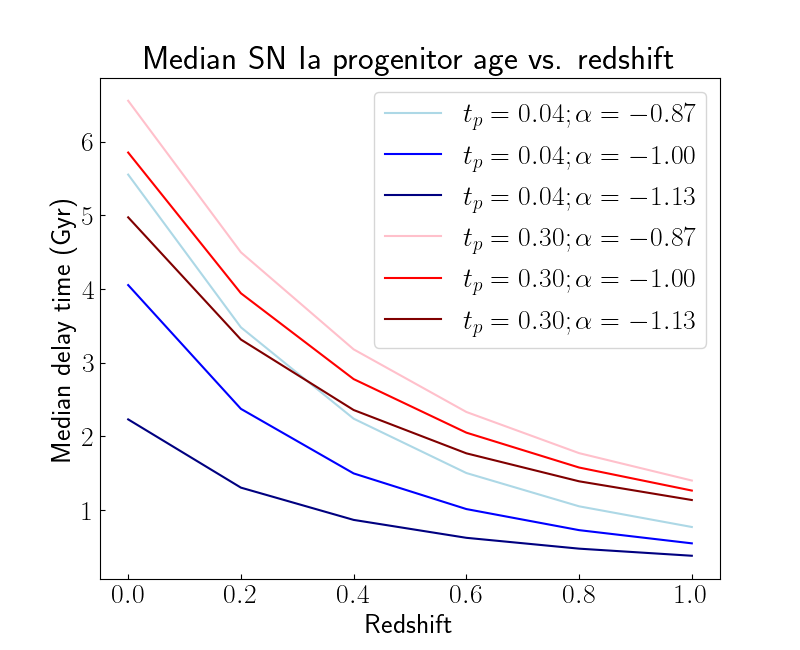

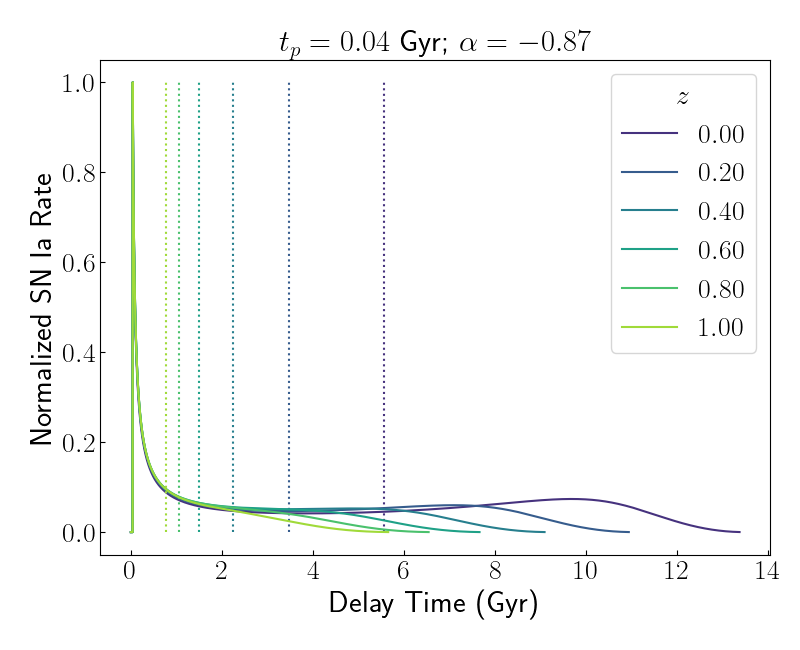

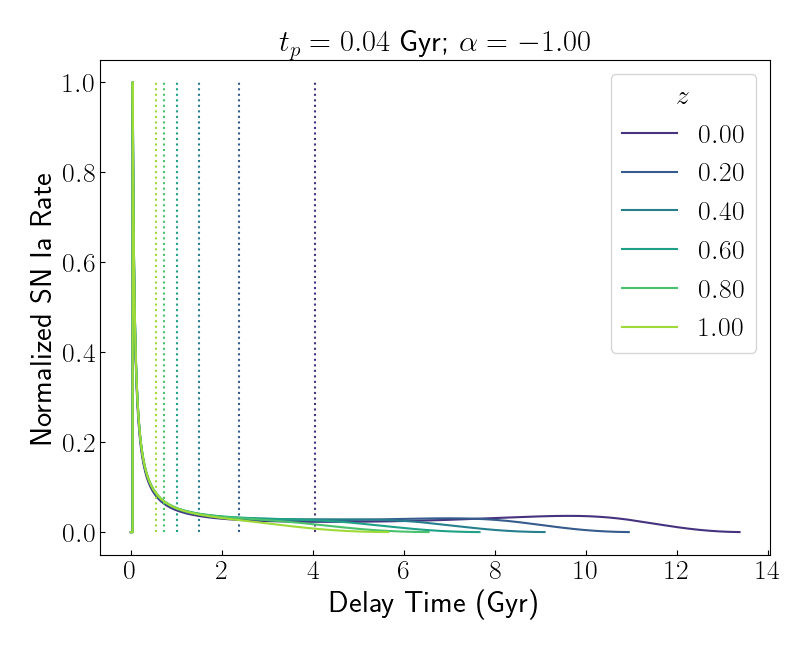

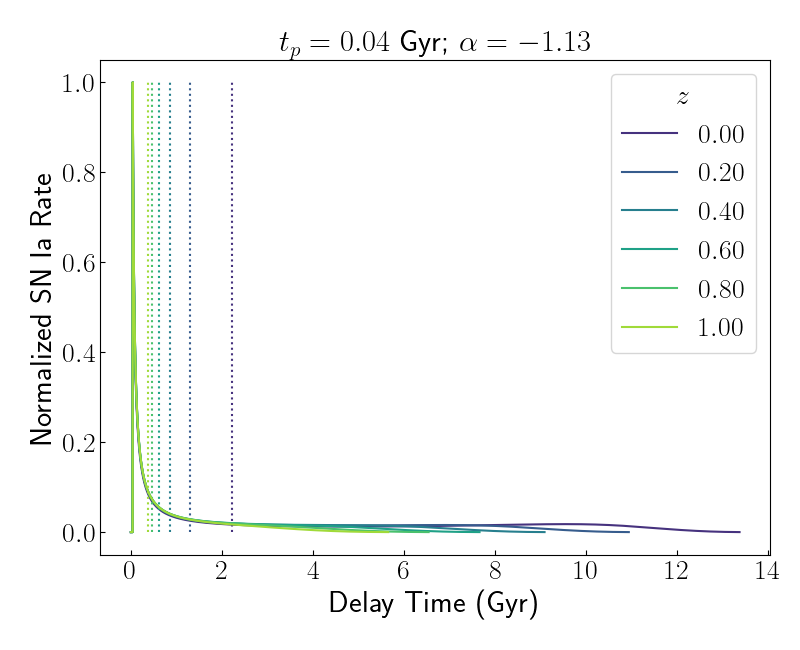

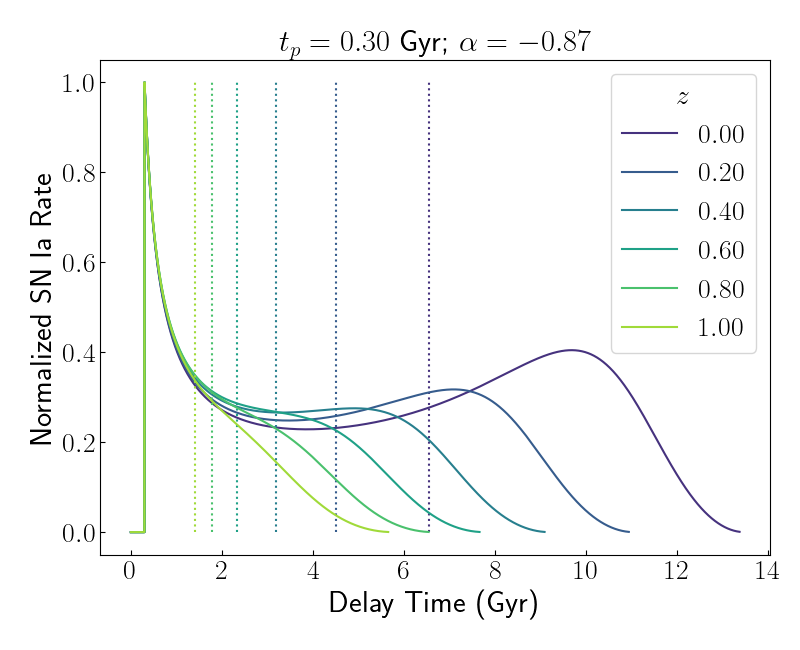

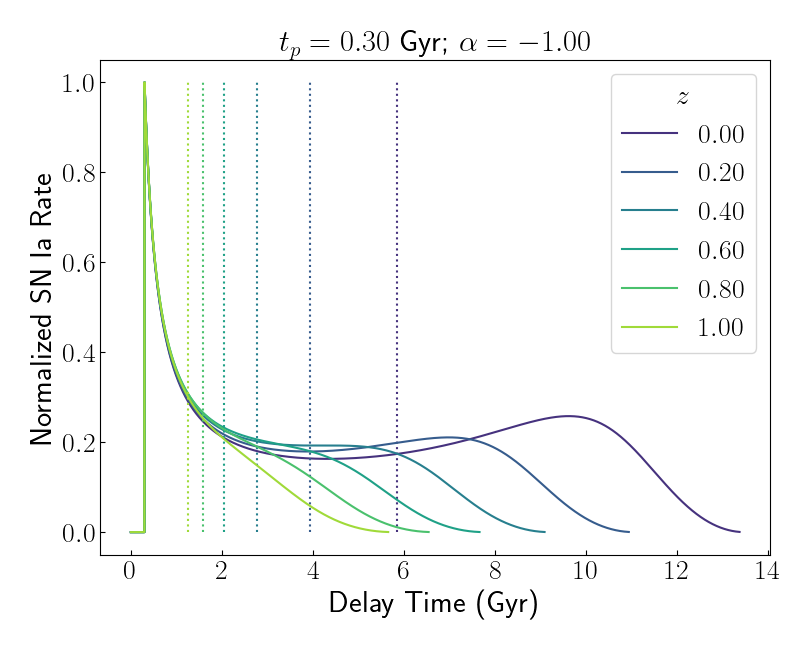

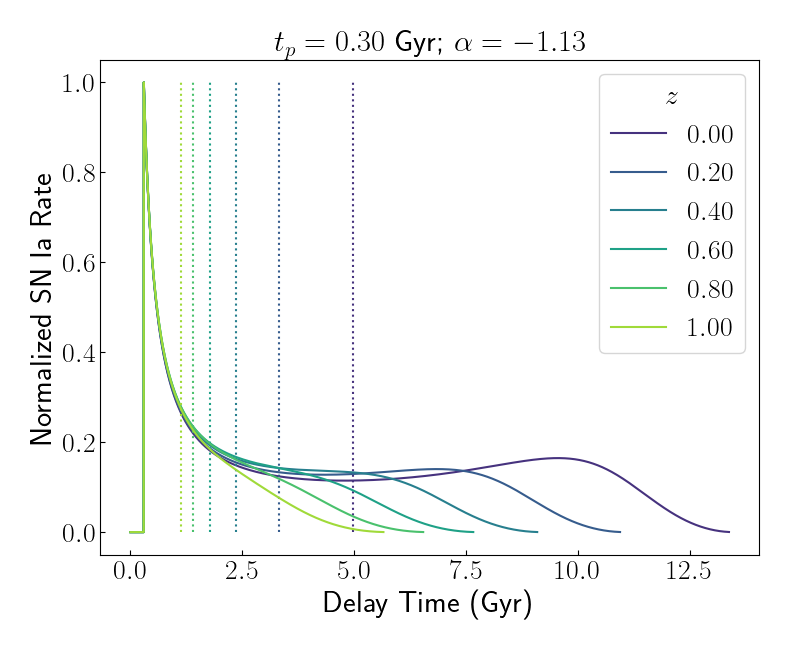

In [67]:
def median_delay_time(z, tp=0.04, s=-1.0,ax=None,c='c'):
    t_obs = cosmo.age(z).value
    mask = t_grid < t_obs
    t_birth = t_grid[mask]
    delay = t_obs - t_birth
    sfr = csfh_grid[mask]
    dtd = phi_t_pl(delay, tp=tp, s=s)
    weight = sfr * dtd
    pdf = weight / np.max(weight)  # normalized delay-time PDF
    cdf = np.cumsum(pdf)
    cdf /= cdf[-1]
    median_idx = np.searchsorted(cdf, 0.5)
    ax.plot(delay,pdf,label='$%.2f$'%z,color=c)
    ax.vlines(delay[median_idx],0,np.max(pdf),color=c,ls=':')
    return delay[median_idx]

f,ax=plt.subplots(figsize=(8,6.5))
# Calculate and plot
z_vals = np.linspace(0, 1., 6)
colours = itertools.cycle(['lightblue','blue','navy','pink','red','maroon'])
zcolours = itertools.cycle(sns.color_palette('viridis',n_colors=len(z_vals)))
for tp in [0.04,0.3]:
    for s in [-0.87,-1,-1.13]:
        fpdf,axpdf = plt.subplots(figsize=(8,6.5))
        c=next(colours)
        
        median_delays = np.array([median_delay_time(z,tp=tp,s=s,ax=axpdf,c=next(zcolours)) for z in z_vals])
        axpdf.legend(title=r'$z$')
        axpdf.set_title(rf'$t_p={tp:.2f}$ Gyr; $\alpha={s:.2f}$',size=22)
        axpdf.set_xlabel('Delay Time (Gyr)',size=22)
        axpdf.set_ylabel('Normalized SN Ia Rate',size=22)
        plt.tight_layout()
        plt.savefig(rf'tp_{tp:.2f}_alpha_{s:.2f}.png')
        ax.plot(z_vals, median_delays,label=rf'$t_p = %.2f; \alpha=%.2f$'%(tp,s),color=c)
ax.legend()
ax.set_xlabel("Redshift")
ax.set_ylabel("Median delay time (Gyr)")
ax.set_title("Median SN Ia progenitor age vs. redshift")

plt.tight_layout()
plt.gca()
plt.savefig('median_delay_times.png')

In [ ]:
df = pd.read_hdf('aura/DES_BS20_age_Rv_step_3Gyr_age_x1_beta_1.14_SN_sim.h5')
df2 = pd.read_hdf('aura/DES_BS20_age_Rv_step_3Gyr_age_x1_beta_1.14_lowz_SN_sim.h5')
df = pd.concat([df,df2])
df['log(SN age)'] = np.log10(df['SN_age'])
df['z'] = np.round(df['z'],3)
df_masked = df[df['eff_mask']>0]

In [43]:
df['z'].max()

0.75

In [ ]:
import itertools
palette=itertools.cycle(sns.color_palette('magma',n_colors=len(df_masked['z'].unique())))
f,(axes)=plt.subplots(len(df_masked['z'].unique()),figsize=(8,20),sharex=True,)
axes = itertools.cycle(axes)
for counter,(n,g) in enumerate(df_masked.groupby('z')):
    ax=next(axes)
    ax.hist(g['SN_age'],bins=10,histtype='step',lw=3,alpha=0.35,color=next(palette),label='%.2f'%n,density=True)
    ax.vlines(g['SN_age'].median(),0,1)
    ax.set_yticks([])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
    ax.tick_params(which='both',top=True,direction='in')
plt.subplots_adjust(wspace=0,hspace=0)


palette=itertools.cycle(sns.color_palette('magma',n_colors=len(df['z'].unique())))
f,(axes)=plt.subplots(len(df['z'].unique()),figsize=(8,20),sharex=True,)
axes = itertools.cycle(axes)
for counter,(n,g) in enumerate(df.groupby('z')):
    ax=next(axes)
    ax.hist(g['SN_age'],bins=10,histtype='step',lw=3,alpha=0.35,color=next(palette),label='%.2f'%n,density=True)
    ax.vlines(g['SN_age'].median(),0,1)
    ax.set_yticks([])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
    ax.tick_params(which='both',top=True,direction='in')
plt.subplots_adjust(wspace=0,hspace=0)

1297
1353
3799
1029
1055
2735


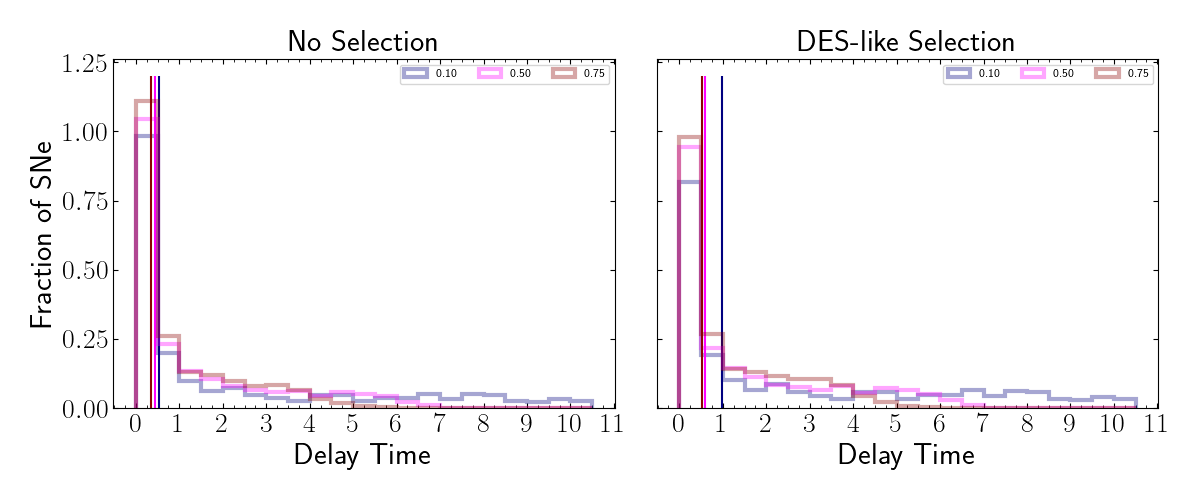

In [78]:
palette=itertools.cycle(['navy','magenta','darkred'])
f,(ax,ax2)=plt.subplots(1,2,figsize=(12,5),sharex=True,)

for n in [0.1,0.5,0.75]:
    if n<0.2:
        g =df[df['z']<=n]
    else:
        g = df[df['z']==n]
    
    
    print(len(g))
    c=next(palette)
    ax.hist(g['SN_age'],bins=np.arange(0,11,0.5),histtype='step',lw=3,alpha=0.35,color=c,label='%.2f'%n,density=True)
    ax.vlines(g['SN_age'].median(),0,1.2,color=c)
    #ax.set_yticks([])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
ax.tick_params(which='both',top=True,right=True,direction='in')
ax.set_xlabel('Delay Time',size=22)
ax.set_ylabel('Fraction of SNe',size=22)
ax.set_title('No Selection',size=22)
ax.legend(ncol=5,fontsize=8)
plt.subplots_adjust(wspace=0,hspace=0)
plt.tight_layout()
plt.savefig('W22_SN_Ages_no_selection.png')

for n in [0.1,0.5,0.75]:
    if n<0.2:
        g =df_masked[df_masked['z']<=n]
    else:
        g = df_masked[df_masked['z']==n]
    g = g[g['mass']>1E8]
    print(len(g))
    c=next(palette)
    ax2.hist(g['SN_age'],bins=np.arange(0,11,0.5),histtype='step',lw=3,alpha=0.35,color=c,label='%.2f'%n,density=True)
    ax2.vlines(g['SN_age'].median(),0,1.2,color=c)
ax2.set_yticklabels('')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
ax2.tick_params(which='both',top=True,right=True,direction='in')
ax2.set_xlabel('Delay Time',size=22)
ax2.set_title('DES-like Selection',size=22)
ax2.legend(ncol=5,fontsize=8)
plt.subplots_adjust(wspace=0,hspace=0)
plt.tight_layout()
plt.savefig('W22_SN_Ages_selection.png')

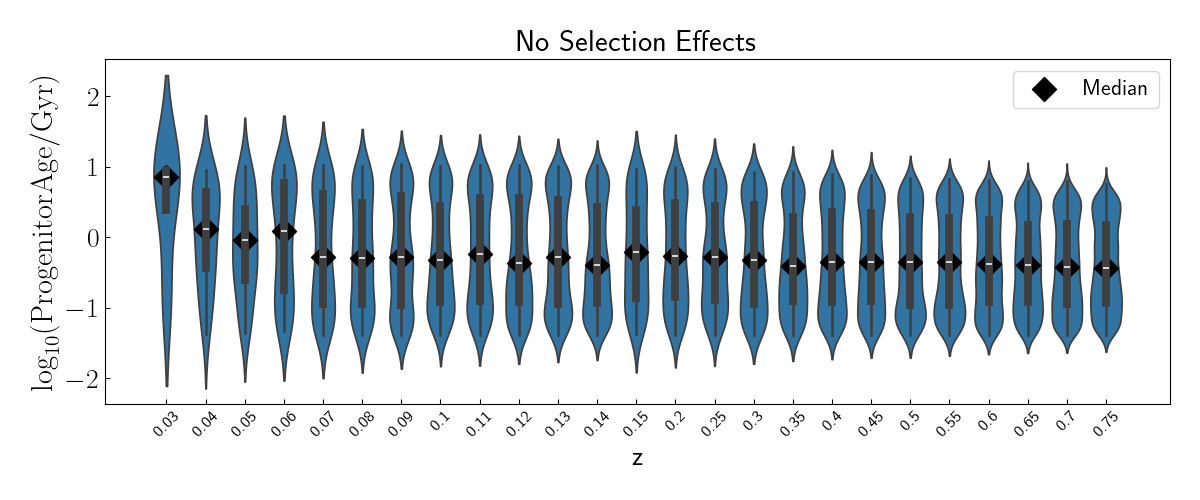

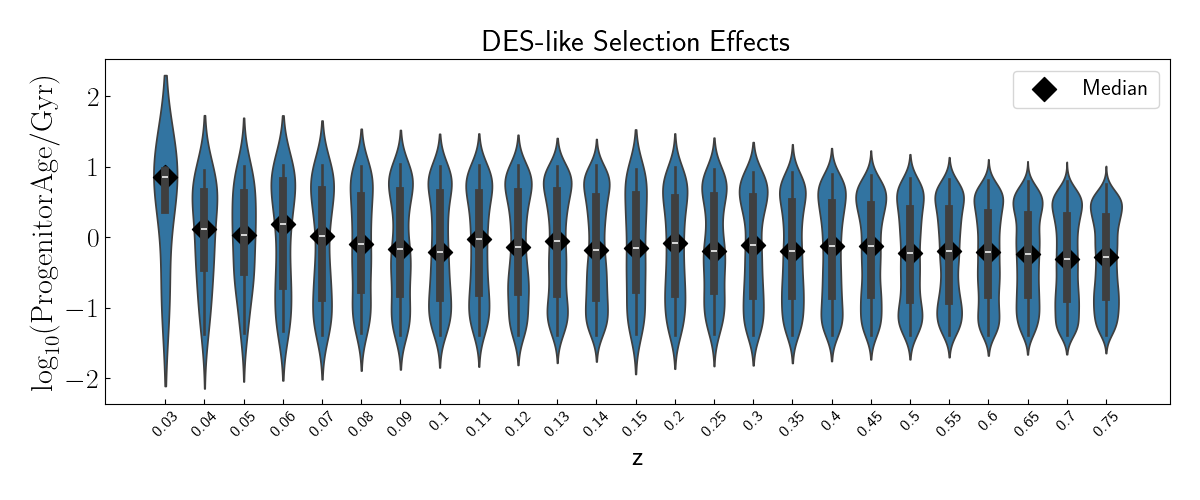

In [ ]:
f,ax=plt.subplots(figsize=(12,5))
sns.violinplot(df,x='z',y='log(SN age)',ax=ax)

ax.tick_params(axis='x',labelsize=12,rotation=45)

for counter,(n,g) in enumerate(df.groupby('z')):
    label=None
    if counter==0:
        label='Median'
    ax.scatter(counter,g['log(SN age)'].median(),marker='D',color='k',s=150,label=label)
ax.legend(fontsize=16)

ax.set_ylabel(r'$\log_{10}({\rm Progenitor Age/Gyr})$',size=22)
#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.set_title('No Selection Effects',size=22)
plt.tight_layout()
plt.savefig('age_vs_z_nosel.png')



f,ax=plt.subplots(figsize=(12,5))
sns.violinplot(df_masked,x='z',y='log(SN age)',ax=ax)

ax.tick_params(axis='x',labelsize=12,rotation=45)

for counter,(n,g) in enumerate(df_masked.groupby('z')):
    label=None
    if counter==0:
        label='Median'
    ax.scatter(counter,g['log(SN age)'].median(),marker='D',color='k',s=150,label=label)
ax.legend(fontsize=16)

ax.set_ylabel(r'$\log_{10}({\rm Progenitor Age/Gyr})$',size=22)
#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.set_title('DES-like Selection Effects',size=22)
plt.tight_layout()
plt.savefig('age_vs_z_DESsel.png')

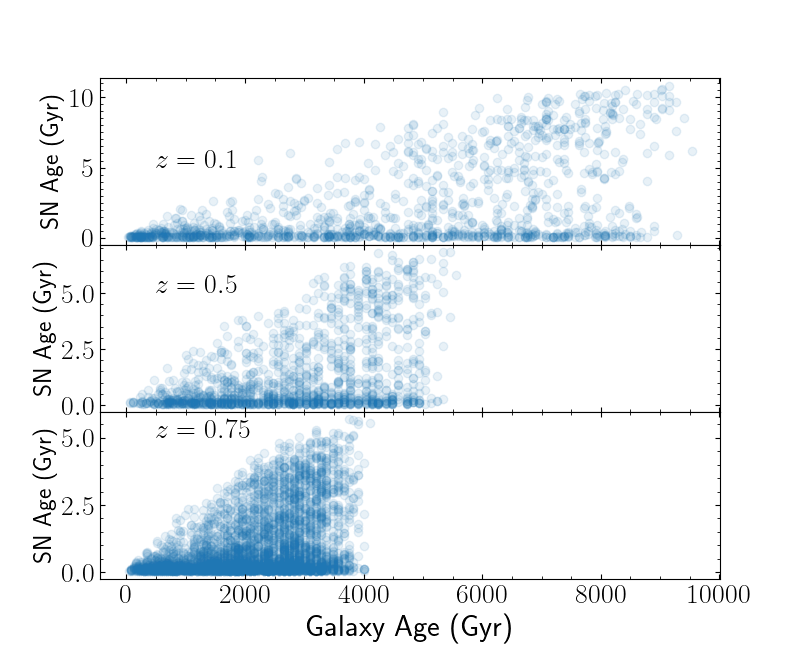

In [90]:
f,(ax1,ax2,ax3)=plt.subplots(3,figsize=(8,6.5),sharex=True)
lowz = df[df['z']<=0.1]
z05 = df[df['z']==0.5]
z075 = df[df['z']==0.75]
ax1.scatter(lowz['mean_ages'],lowz['SN_age'],alpha=0.1)
ax1.set_ylabel('SN Age (Gyr)',size=18)
ax1.text(500,5,r'$z=0.1$')
ax2.scatter(z05['mean_ages'],z05['SN_age'],alpha=0.1)
ax2.set_ylabel('SN Age (Gyr)',size=18)
ax2.text(500,5,r'$z=0.5$')
ax3.scatter(z075['mean_ages'],z075['SN_age'],alpha=0.1)
ax3.set_ylabel('SN Age (Gyr)',size=18)
ax3.text(500,5,r'$z=0.75$')
ax3.set_xlabel('Galaxy Age (Gyr)',size=22)
plt.subplots_adjust(wspace=0,hspace=0)
for ax in [ax1,ax2,ax3]:
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(500))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    ax.tick_params(which='both',direction='in',top=True,right=True)
    

In [98]:
from scipy.stats import norm
SNdiff = df['SN_age'].apply(lambda x: -0.1 if x>1 else 0.1)
SNdiff = norm(SNdiff,np.ones_like(SNdiff)*0.1).rvs()
df['SNdiff']=SNdiff

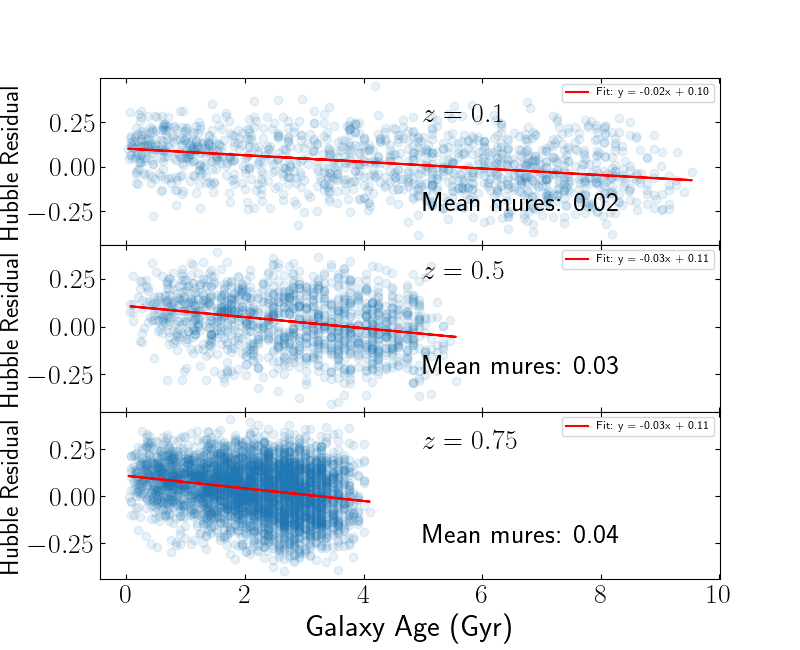

In [111]:
from scipy.optimize import curve_fit
# Define a linear model
def linear_model(x, m, c):
    return m * x + c

f,(ax1,ax2,ax3)=plt.subplots(3,figsize=(8,6.5),sharex=True)
lowz = df[df['z']<=0.1]
z05 = df[df['z']==0.5]
z075 = df[df['z']==0.75]
ax1.scatter(lowz['mean_ages']/1000,lowz['SNdiff'],alpha=0.1)
params, covariance = curve_fit(linear_model, lowz['mean_ages'],lowz['SNdiff'])
slope, intercept = params
ax1.plot(lowz['mean_ages']/1000, linear_model(lowz['mean_ages'], *params), 'r-', label=f'Fit: y = {slope*1000:.2f}x + {intercept:.2f}')

ax1.set_ylabel('Hubble Residual',size=18)
ax1.text(5,0.25,r'$z=0.1$')
ax1.text(5,-0.25,f'Mean mures: {np.mean(lowz['SNdiff']):.2f}')
#ax1.text(0,-0.25,r'$z=0.1$')
###
ax1.legend(fontsize=8)
ax2.scatter(z05['mean_ages']/1000,z05['SNdiff'],alpha=0.1)
params, covariance = curve_fit(linear_model, z05['mean_ages'],z05['SNdiff'])
slope, intercept = params
ax2.plot(z05['mean_ages']/1000, linear_model(z05['mean_ages'], *params), 'r-', label=f'Fit: y = {slope*1000:.2f}x + {intercept:.2f}')
ax2.set_ylabel('Hubble Residual',size=18)
ax2.text(5,0.25,r'$z=0.5$')
ax2.text(5,-0.25,f'Mean mures: {np.mean(z05['SNdiff']):.2f}')
#ax2.text(0,-0.25,r'$z=0.5$')
ax2.legend(fontsize=8)
#
ax3.scatter(z075['mean_ages']/1000,z075['SNdiff'],alpha=0.1)
params, covariance = curve_fit(linear_model, z075['mean_ages'],z075['SNdiff'])
slope, intercept = params
ax3.plot(z075['mean_ages']/1000, linear_model(z075['mean_ages'], *params), 'r-', label=f'Fit: y = {slope*1000:.2f}x + {intercept:.2f}')
ax3.set_ylabel('Hubble Residual',size=18)
ax3.text(5,0.25,r'$z=0.75$')
ax3.text(5,-0.25,f'Mean mures: {np.mean(z075['SNdiff']):.2f}')
#ax3.text(0,-0.25,r'$z=0.75$')
ax3.legend(fontsize=8)
ax3.set_xlabel('Galaxy Age (Gyr)',size=22)
plt.subplots_adjust(wspace=0,hspace=0)
for ax in [ax1,ax2,ax3]:
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(500))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    ax.tick_params(which='both',direction='in',top=True,right=True)
plt.savefig('murespred.png')    

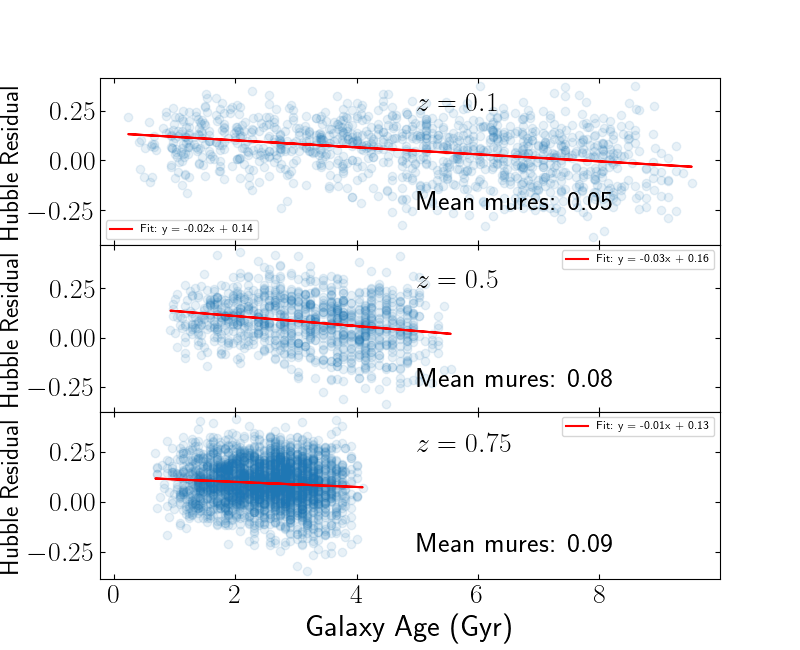

In [114]:
from scipy.optimize import curve_fit
# Define a linear model
def linear_model(x, m, c):
    return m * x + c
SNdiff = df_masked['SN_age'].apply(lambda x: -0.1 if x>4 else 0.1)
SNdiff = norm(SNdiff,np.ones_like(SNdiff)*0.1).rvs()
df_masked['SNdiff']=SNdiff
f,(ax1,ax2,ax3)=plt.subplots(3,figsize=(8,6.5),sharex=True)
lowz = df_masked[df_masked['z']<=0.1]
z05 = df_masked[df_masked['z']==0.5]
z075 = df_masked[df_masked['z']==0.75]
ax1.scatter(lowz['mean_ages']/1000,lowz['SNdiff'],alpha=0.1)
params, covariance = curve_fit(linear_model, lowz['mean_ages'],lowz['SNdiff'])
slope, intercept = params
ax1.plot(lowz['mean_ages']/1000, linear_model(lowz['mean_ages'], *params), 'r-', label=f'Fit: y = {slope*1000:.2f}x + {intercept:.2f}')

ax1.set_ylabel('Hubble Residual',size=18)
ax1.text(5,0.25,r'$z=0.1$')
ax1.text(5,-0.25,f'Mean mures: {np.mean(lowz['SNdiff']):.2f}')
#ax1.text(0,-0.25,r'$z=0.1$')
###
ax1.legend(fontsize=8)
ax2.scatter(z05['mean_ages']/1000,z05['SNdiff'],alpha=0.1)
params, covariance = curve_fit(linear_model, z05['mean_ages'],z05['SNdiff'])
slope, intercept = params
ax2.plot(z05['mean_ages']/1000, linear_model(z05['mean_ages'], *params), 'r-', label=f'Fit: y = {slope*1000:.2f}x + {intercept:.2f}')
ax2.set_ylabel('Hubble Residual',size=18)
ax2.text(5,0.25,r'$z=0.5$')
ax2.text(5,-0.25,f'Mean mures: {np.mean(z05['SNdiff']):.2f}')
#ax2.text(0,-0.25,r'$z=0.5$')
ax2.legend(fontsize=8)
#
ax3.scatter(z075['mean_ages']/1000,z075['SNdiff'],alpha=0.1)
params, covariance = curve_fit(linear_model, z075['mean_ages'],z075['SNdiff'])
slope, intercept = params
ax3.plot(z075['mean_ages']/1000, linear_model(z075['mean_ages'], *params), 'r-', label=f'Fit: y = {slope*1000:.2f}x + {intercept:.2f}')
ax3.set_ylabel('Hubble Residual',size=18)
ax3.text(5,0.25,r'$z=0.75$')
ax3.text(5,-0.25,f'Mean mures: {np.mean(z075['SNdiff']):.2f}')
#ax3.text(0,-0.25,r'$z=0.75$')
ax3.legend(fontsize=8)
ax3.set_xlabel('Galaxy Age (Gyr)',size=22)
plt.subplots_adjust(wspace=0,hspace=0)
for ax in [ax1,ax2,ax3]:
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(500))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    ax.tick_params(which='both',direction='in',top=True,right=True)
plt.savefig('murespred_masked.png')    